# PINNs on directed graphs

In this notebook, we focus on the solution of transport equations on directed graphs.
To be more precise, we consider the transport equation

$$
\partial_t u + \partial_x (u \, (1-u)) = \partial_t u + \partial_x u - 2 \, u \, \partial_x u = 0
$$

with appropriate boundary conditions.

Import necessary packages.

In [1]:
import tensorflow as tf
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt

In /home/blja/miniconda3/envs/tensorflow/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/blja/miniconda3/envs/tensorflow/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/blja/miniconda3/envs/tensorflow/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/blja/miniconda3/envs/tensorflow/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.


## Set up class GraphPINNs

Next, we define the class `GraphPINN`, which is employed in the subsequent code.
The idea is to have one vanilla `PINN` for each edge which are connected via boundary and vertex conditions which are enforced weakly.

---

First, we define the model for a `PINN` which consists of one scaling layer, a number of fully connected hidden layers and one final output layer.

In [2]:
# Define model architecture
class PINN(tf.keras.Model):
    """ Set basic architecture of the PINN model."""

    def __init__(self, lb, ub,
                 output_dim=1,
                 num_hidden_layers=8,
                 num_neurons_per_layer=20,
                 activation='tanh',
                 kernel_initializer='glorot_normal',
                 **kwargs):
        
        super().__init__(**kwargs)

        self.num_hidden_layers = num_hidden_layers
        self.input_dim = lb.shape[0]
        self.output_dim = output_dim
        self.lb = lb
        self.ub = ub

        # Define NN architecture
        
        # Scaling layer to map inpot to the interval [-1, 1]
        self.scale = tf.keras.layers.Lambda(
            lambda x: 2.0 * (x - lb) / (ub - lb) - 1.0)
        
        # Inititialize num_hidden_layers many fully connected dense layers
        self.hidden = [tf.keras.layers.Dense(num_neurons_per_layer,
                                             activation=tf.keras.activations.get(
                                                 activation),
                                             kernel_initializer=kernel_initializer) for _ in range(self.num_hidden_layers)]
        
        # Output layer
        self.out = tf.keras.layers.Dense(output_dim, activation=None)

    def call(self, X):
        """Forward-pass through neural network."""
        
        Z = self.scale(X)
        
        for i in range(self.num_hidden_layers):
            Z = self.hidden[i](Z)
            
        return self.out(Z)

In this notebook, we rely on the package [NetworkX](https://networkx.org/).
An alternative approach would be to employ [igraph](https://igraph.org/), which seems to be more lightweight.

Next, we set up the class for a graph PINN which takes either an adjacency matrix $A$ or a `MultiDiGraph` as input `inp` to define the network as well as the Dirichlet data as a list of pairs $(i, u_i)_{i=1}^{n_D}$ corresponding to $u(v_i) = u_i$.
*Notes*:
- we define our graph as a `MultiDiGraph` since graphs imported from [OpenStreetMap](https://www.openstreetmap.de/) obey this format.

In [156]:
import networkx as nx

class GraphPINN():
    
    def __init__(self, inp, dirichletData, lb, ub):
        
        if isinstance(inp, nx.classes.multidigraph.MultiGraph):
            self.G = inp
            self.A = nx.adjacency_matrix(G).toarray()
            
        elif tf.is_tensor(A) and len(A.shape)==2:
            # Store adjacency matrix
            self.A = A
            # Define networkx multigraph
            self.G = nx.MultiDiGraph(A.numpy())
            
        else:
            raise ValueError('Check input type of GraphPINN.')
        
        self.dirichletData = dirichletData
        self.lb = lb
        self.ub = ub
        
        # Get number of vertices
        self.n_v = self.A.shape[0]
        
        # Determine lists of edges and lengths
        self._determineEdgeList()
        
        # Determine list of vertices and incoming as well as outgoing edges
        self._determineVertexList()
        
        # Setup list of neural networks
        self._setupNNs()
        
        # Setup list of vertex values in inner nodes
        self._setupVertexVariables()
        
    def _determineEdgeList(self):
        """Determine edge matrix and weight vector.
        This could also be accomplished by a loop over `G.edges`:
            for e in G.edges:
                print(e)
        """
        
        self.E = []
        self.W = []
        
        for i in range(self.n_v):
            for j in range(i + 1, self.n_v):
                aij = self.A[i, j]
                if aij > 0:
                    #print('Connectivity between i: {} and j: {}'.format(i,j))
                    self.E.append([i, j])
                    self.W.append(aij.numpy())

        # Get number of edges
        self.n_e = len(self.E)
        
    def _determineVertexList(self):
        self.Vin = []
        self.Vout = []
        self.innerVertices = []

        for i in range(self.n_v):
            # Get incoming edges of vertex i
            tmp = np.where(self.A[:,i]>0)[0]
            self.Vin.append(tmp.tolist())
            
            # Get outgoing edeges of vertex i
            tmp = np.where(self.A[i,:]>0)[0]
            self.Vout.append(tmp.tolist())
            
            if self.Vin[i] and self.Vout[i]:
                self.innerVertices.append(i)
            
    def _setupNNs(self):
        
        self.NNs = []
        for i, e in enumerate(self.E):
            self.NNs.append(PINN(lb=self.lb, ub=self.ub))
    
        print('Initialized {:d} neural nets.'.format(len(self.NNs)))
    
    def _setupVertexVariables(self):
        
        self.vertexVals = []
        for i in self.innerVertices:
            self.vertexVals.append(tf.Variable(0.0, trainable=True, dtype=DTYPE))
        
    def plotGraph(self, **kwargs):
        
        # Determine graph layout if necessary
        if not hasattr(self, 'pos'):
            self.pos = nx.kamada_kawai_layout(self.G)
            
        nx.draw(self.G, pos=self.pos, with_labels=True, **kwargs)

### Example

First, we define a network which is determined by its
adjacency matrix $A \in \mathbb{R}_+^{n_v \times n_v}$ with $n_v$ the number of vertices.
Note that this matrix is not symmetric, as it belongs to a *directed* graph.
Here, an entry $a_{i,j} > 0$ indicates that there is an edge starting in vertex $i$ and ending in vertex $j$ with length $a_{i,j}$.

In [157]:
DTYPE = 'float32'

# Specify adjacency matrix
A = tf.constant([[0, 1, 0, 0, 0, 0, 0, 0],
                 [0, 0, 1, 0, 1, 0, 0, 0],
                 [0, 0, 0, 1, 1, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 1, 0],
                 [0, 0, 0, 0, 0, 1, 0, 0],
                 [0, 0, 0, 0, 0, 0, 1, 0],
                 [0, 0, 0, 0, 0, 0, 0, 1],
                 [0, 0, 0, 0, 0, 0, 0, 0]
                ], dtype=tf.int16)

dirichletData = [(0, .0)]

# Set boundaries
tmin = 0.
tmax = 20.
xmin = 0.
xmax = 1.

# Lower bounds
lb = tf.constant([tmin, xmin], dtype=DTYPE)

# Upper bounds
ub = tf.constant([tmax, xmax], dtype=DTYPE)

Initialized 9 neural nets.


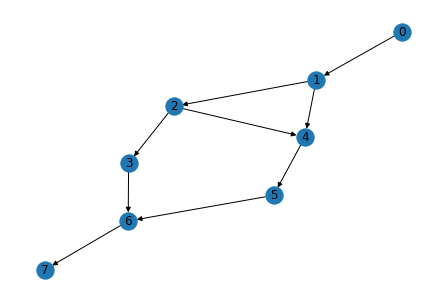

In [158]:
%matplotlib inline

gPINN = GraphPINN(A, dirichletData, lb, ub)
gPINN.plotGraph()

## Set up class for time-dependent equations

We have to handle different kinds of boundary and vertex conditions:
- all inner vertices: Kirchhoff-Neumann conditon
- initial time conditions on all edges
- Dirichlet conditions on selected vertices as long as it is an inflowing node

In [159]:
class graphPINNSolver(object):
    def __init__(self, graphPINN, X_r):
        
        # Store collocation points
        self.N_r = X_r.shape[0]
        
        self.graphPINN = graphPINN
        
        n_e = self.graphPINN.n_e
        
        self.t = [ X_r[:,0:1]
                      for i in range(n_e)]
        self.x = [ X_r[:,1:2]
                      for i in range(n_e)]
        
        self.t0nodes = np.where(X_r[:,0] < lb[0]+1e-13)[0]
        self.x0nodes = np.where(X_r[:,1] < lb[1]+1e-13)[0]
        self.xLnodes = np.where(X_r[:,1] > ub[1]-1e-13)[0]

        # Initialize history of losses and global iteration counter
        self.hist = []
        self.iter = 0
        
        # Call each network once to initialize trainable variables
        self.trainable_variables = []
        for i in range(n_e):
            self.graphPINN.NNs[i](tf.constant([[1., 1.]]))
            self.trainable_variables.append(self.graphPINN.NNs[i].trainable_variables)

        #self.trainable_variables = [self.graphPINN.NNs[i].trainable_variables
        #                            for i in range(n_e)]
        for i, v in enumerate(self.graphPINN.innerVertices):
            self.trainable_variables.append(self.graphPINN.vertexVals[i])

    def get_fvals1(self, t=None, x=None):

        # Initilize lists for values and derivatives
        u = []
        u1x = []
        u1t = []
        
        if t is None:
            t = self.t
        if x is None:
            x = self.x
            
        
        with tf.GradientTape(persistent=True) as tape:
            # Watch variables representing t and x during this GradientTape
            tape.watch(t)
            tape.watch(x)
            
            # Compute current values u(t,x)
            u = []
            for i in range(self.graphPINN.n_e):
                u.append(self.graphPINN.NNs[i](tf.stack([t[i][:,0], x[i][:,0]], axis=1)))
                
        for i in range(self.graphPINN.n_e):
            u1t.append(tape.gradient(u[i], t[i]))
            u1x.append(tape.gradient(u[i], x[i]))

        del tape

        return u, u1t, u1x
    
    def get_fvals2(self, t=None, x=None):

        # Initilize lists for values and derivatives
        u = []
        u1x = []
        u2x = []
        u1t = []
        
        if t is None:
            t = self.t
        if x is None:
            x = self.x
        
        with tf.GradientTape(persistent=True) as tape:
            # Watch variables representing t and x during this GradientTape
            tape.watch(t)
            tape.watch(x)
            
            # Compute current values u(t,x)
            u = []
            for i in range(self.graphPINN.n_e):
                u.append(self.graphPINN.NNs[i](tf.stack([t[i][:,0], x[i][:,0]], axis=1)))
                u1x.append(tape.gradient(u[i], x[i]))
                
        for i in range(self.graphPINN.n_e):
            u1t.append(tape.gradient(u[i], t[i]))
            u2x.append(tape.gradient(u1x[i], x[i]))
        
        del tape

        return u, u1t, u1x, u2x

    def fun_r2(self, u, u1t, u1x, u2x):
        ret = []
        for i in range(self.graphPINN.n_e):
            #ret.append(u1t[i] + u1x[i] - 0.1*u2x[i]-1.)
            ret.append(u1t[i] + u1x[i] - 2*u[i]*u1x[i])

        return ret
    
    def fun_r1(self, u, u1t, u1x):
        ret = []
        for i in range(self.graphPINN.n_e):
            ret.append(u1t[i] + u1x[i] - 2*u[i]*u1x[i])

        return ret
    
    @tf.function
    def loss_fn(self):
        
        # Get values of functions and derivatives
        #u, u1t, u1x, u2x = self.get_fvals2()
        
        # Compute phi_r
        #r = self.fun_r2(u, u1t, u1x, u2x)
        
        # Get values of functions and derivatives
        u, u1t, u1x = self.get_fvals1()
        
        # Compute phi_r
        r = self.fun_r1(u, u1t, u1x)
        phi_r = tf.reduce_mean(tf.square(r))

        # Initialize loss
        loss = phi_r
        
        x0nodes = slice(0,N_t+1)
        xLnodes = slice(-N_t-1,None)
        t0nodes = slice(0,None,N_t+1)
        
        # Initial time condition
        loss += tf.reduce_mean(tf.square(u[0][t0nodes] - 0.0))
        for i in range(1,self.graphPINN.n_e):
            loss += tf.reduce_mean(tf.square(u[i][t0nodes]-0.0))
        #    loss += tf.reduce_mean(tf.square(u[i][t0nodes] - tf.sin(X_r[t0nodes,1]*np.pi)))
        
        # Continuity in center node
        for i,v in enumerate(self.graphPINN.innerVertices):
            for j in self.graphPINN.Vin[v]:
                loss += tf.reduce_mean(tf.square(u[j][xLnodes] - self.graphPINN.vertexVals[i]))
            for j in self.graphPINN.Vout[v]:
                loss += tf.reduce_mean(tf.square(u[j][x0nodes] - self.graphPINN.vertexVals[i]))

        
        if False:
            # Vertex 1
            loss += tf.reduce_mean(tf.square(u[0][xLnodes] - u[1][x0nodes]))
            loss += tf.reduce_mean(tf.square(u[0][xLnodes] - u[2][x0nodes]))
            loss += tf.reduce_mean(tf.square(u[1][x0nodes] - u[2][x0nodes]))        
            # Vertex 2
            loss += tf.reduce_mean(tf.square(u[1][xLnodes] - u[3][x0nodes]))
            loss += tf.reduce_mean(tf.square(u[1][xLnodes] - u[4][x0nodes]))
            loss += tf.reduce_mean(tf.square(u[3][x0nodes] - u[4][x0nodes]))
            # Vertex 3
            loss += tf.reduce_mean(tf.square(u[3][xLnodes] - u[5][x0nodes]))
            # Vertex 4
            loss += tf.reduce_mean(tf.square(u[2][xLnodes] - u[4][xLnodes]))
            loss += tf.reduce_mean(tf.square(u[2][xLnodes] - u[6][x0nodes]))
            loss += tf.reduce_mean(tf.square(u[4][xLnodes] - u[6][x0nodes]))
            # Vertex 5
            loss += tf.reduce_mean(tf.square(u[6][xLnodes] - u[7][x0nodes]))
            # Vertex 6
            loss += tf.reduce_mean(tf.square(u[5][xLnodes] - u[7][xLnodes]))
            loss += tf.reduce_mean(tf.square(u[5][xLnodes] - u[8][x0nodes]))
            loss += tf.reduce_mean(tf.square(u[7][xLnodes] - u[8][x0nodes]))

        
        # Kirchhoff-Neumann condition in center nodes
        for i in self.graphPINN.innerVertices:
            tmp = 0
            for j in self.graphPINN.Vin[i]:
                tmp += u1x[j][xLnodes]
            for j in self.graphPINN.Vout[i]:
                tmp -= u1x[j][x0nodes]
            loss += tf.reduce_mean(tf.square(tmp))
        
        if False:
            # Vertex 1
            loss += tf.reduce_mean(tf.square(u1x[0][xLnodes] - u1x[1][x0nodes] - u1x[2][x0nodes]))
            # Vertex 2
            loss += tf.reduce_mean(tf.square(u1x[1][xLnodes] - u1x[3][x0nodes] - u1x[4][x0nodes]))
            # Vertex 3
            loss += tf.reduce_mean(tf.square(u1x[3][xLnodes] - u1x[5][x0nodes]))
            # Vertex 4
            loss += tf.reduce_mean(tf.square(u1x[2][xLnodes] + u1x[4][xLnodes] - u1x[6][x0nodes]))
            # Vertex 5
            loss += tf.reduce_mean(tf.square(u1x[6][xLnodes] - u1x[7][x0nodes]))
            # Vertex 6
            loss += tf.reduce_mean(tf.square(u1x[5][xLnodes] + u1x[7][xLnodes] - u1x[8][x0nodes]))


        
        # Multiple leaves are Dirichlet nodes
        
        # Dirichlet node is vertex 0
        alpha = 1.
        loss += tf.reduce_mean(tf.square(u[0][x0nodes]-(alpha)))
        #beta = 0.01
        #        loss += tf.cond(u[8][xLnodes] > 0.5, tf.reduce_mean(tf.square(u[8][xLnodes]-(1.-beta))), 0.0)

        return loss    
    
    def get_grad(self):
        with tf.GradientTape(persistent=True) as tape:
            # This tape is for derivatives with
            # respect to trainable variables
            tape.watch(self.trainable_variables)
            loss = self.loss_fn()

        g = tape.gradient(loss, self.trainable_variables)
        del tape

        return loss, g
    
    
    def solve_with_TFoptimizer(self, optimizer, N=1001):
        """This method performs a gradient descent type optimization."""

        for i in range(N):
            loss, g = self.get_grad()

            # Perform gradient descent step
            for j in range(self.graphPINN.n_e):
                optimizer.apply_gradients(zip(g[j], self.trainable_variables[j]))

            self.current_loss = loss.numpy()
            self.callback()
            

    def solve_with_ScipyOptimizer(self, method='L-BFGS-B', **kwargs):
        """This method provides an interface to solve the learning problem
        using a routine from scipy.optimize.minimize.
        (Tensorflow 1.xx had an interface implemented, which is not longer
        supported in Tensorflow 2.xx.)
        Type conversion is necessary since scipy-routines are written in
        Fortran which requires 64-bit floats instead of 32-bit floats."""

        def get_weight_tensor():
            """Function to return current variables of the model
            as 1d tensor as well as corresponding shapes as lists."""

            weight_list = []
            shape_list = []

            # Loop over all variables, i.e. weight matrices, bias vectors
            # and unknown parameters
            for i in range(self.graphPINN.n_e):
                for v in self.graphPINN.NNs[i].variables:
                    shape_list.append(v.shape)
                    weight_list.extend(v.numpy().flatten())

            weight_list = tf.convert_to_tensor(weight_list)
            return weight_list, shape_list

        x0, shape_list = get_weight_tensor()

        def set_weight_tensor(weight_list):
            """Function which sets list of weights
            to variables in the model."""
            idx = 0
            for i in range(self.graphPINN.n_e):
                for v in self.graphPINN.NNs[i].variables:
                    vs = v.shape

                    # Weight matrices
                    if len(vs) == 2:
                        sw = vs[0] * vs[1]
                        new_val = tf.reshape(
                            weight_list[idx:idx + sw], (vs[0], vs[1]))
                        idx += sw

                    # Bias vectors
                    elif len(vs) == 1:
                        new_val = weight_list[idx:idx+vs[0]]
                        idx += vs[0]

                    # Variables (in case of parameter identification setting)
                    elif len(vs) == 0:
                        new_val = weight_list[idx]
                        idx += 1

                    # Assign variables (Casting necessary since scipy requires float64 type)
                    v.assign(tf.cast(new_val, tf.float32))
        
        def get_loss_and_grad(w):
            """Function that provides current loss and gradient
            w.r.t the trainable variables as vector. This is mandatory
            for the LBFGS minimizer from tfp.optimizer."""

            # Update weights in model
            set_weight_tensor(w)
            # Determine value of \phi and gradient w.r.t. \theta at w
            loss, grad = self.get_grad()

            # Flatten gradient
            grad_flat = []
            for i in range(self.graphPINN.n_e):
                for g in grad[i]:
                    grad_flat.extend(g.numpy().flatten())

            # Store current loss for callback function
            self.current_loss = loss

            # Return value and gradient of \phi as tuple
            return loss.numpy().astype(np.float64), np.array(grad_flat, dtype=np.float64)

        return scipy.optimize.minimize(fun=get_loss_and_grad,
                                       x0=x0,
                                       jac=True,
                                       method=method,
                                       callback=self.callback,
                                       **kwargs)

            
    
    def callback(self, xr=None):
        if self.iter % 50 == 0:
            print('It {:05d}: loss = {:10.8e}'.format(
                self.iter, self.current_loss))
        self.hist.append(self.current_loss)
        self.iter += 1
        

    def plot_loss_history(self, ax=None):
        if not ax:
            fig = plt.figure(figsize=(7, 5))
            ax = fig.add_subplot(111)
        ax.semilogy(range(len(self.hist)), self.hist, 'k-')
        ax.set_xlabel('$n_{epoch}$')
        ax.set_ylabel('$\\phi^{n_{epoch}}$')
        return ax

## 2. Solve easy instationary equation

Draw collocation points uniformly or take them equidistantly distributed.

In [161]:
N_0 = 40
N_t = 40
N_x = 40
#N_r = 50

# Set random seed for reproducible results
tf.random.set_seed(0)

# Uniform distributed points for initial boundary data
t_0 = tf.ones((N_0+1,1), dtype=DTYPE)*lb[0]
x_0 = tf.reshape(tf.linspace(lb[1],ub[1],N_0+1), (N_0+1, 1))
X_0 = tf.concat([t_0, x_0], axis=1)

# Uniform distributed collocation points
t_r = tf.linspace(lb[0], ub[0], N_t+1)
x_r = tf.linspace(lb[1], ub[1], N_x+1)
tt, xx = tf.meshgrid(t_r,x_r)
X_r = tf.concat([tf.reshape(tt,(-1,1)), tf.reshape(xx,(-1,1))], axis=1)
# Evaluate intitial condition at x_0
#u_0 = fun_u_0(x_0)


# Draw uniform sample points for initial boundary data
#x_0 = tf.random.uniform((N_0,1), lb[1], ub[1], dtype=DTYPE)

# Draw uniformly sampled collocation points
#t_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
#x_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
#X_r = tf.concat([t_r, x_r], axis=1)

In [162]:
pinn = graphPINNSolver(gPINN,X_r)

In [163]:
# Solve with Adam optimizer
lr = 0.001
optim = tf.keras.optimizers.Adam(learning_rate=lr)
print('Start with TF optimizer\n')
pinn.solve_with_TFoptimizer(optim, N=401)

Start with TF optimizer

It 00000: loss = 1.07641430e+01
It 00050: loss = 1.36594549e-01
It 00100: loss = 7.56100416e-02
It 00150: loss = 6.85818493e-02


SystemError: PyEval_EvalFrameEx returned a result with an error set

In [136]:
print('End with L-BFGS-B algorithm')
pinn.solve_with_ScipyOptimizer()

End with L-BFGS-B algorithm
It 00450: loss = 4.47113812e-02
It 00500: loss = 4.26397100e-02
It 00550: loss = 4.18264568e-02
It 00600: loss = 4.12348174e-02
It 00650: loss = 4.04789113e-02
It 00700: loss = 3.98918875e-02
It 00750: loss = 3.95008363e-02
It 00800: loss = 3.92067581e-02
It 00850: loss = 3.88129801e-02
It 00900: loss = 3.85536328e-02
It 00950: loss = 3.84500585e-02
It 01000: loss = 3.83712202e-02
It 01050: loss = 3.83127555e-02
It 01100: loss = 3.82587835e-02
It 01150: loss = 3.82047296e-02
It 01200: loss = 3.81392837e-02
It 01250: loss = 3.80549282e-02
It 01300: loss = 3.79697531e-02
It 01350: loss = 3.78957987e-02
It 01400: loss = 3.77972126e-02
It 01450: loss = 3.77177224e-02
It 01500: loss = 3.76309603e-02
It 01550: loss = 3.75523940e-02
It 01600: loss = 3.74636091e-02
It 01650: loss = 3.73903252e-02
It 01700: loss = 3.73246893e-02
It 01750: loss = 3.72874439e-02
It 01800: loss = 3.72556895e-02
It 01850: loss = 3.72109823e-02
It 01900: loss = 3.71592008e-02
It 01950: lo

KeyboardInterrupt: 

In [164]:
%matplotlib widget
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
fig = plt.figure(figsize=(16, 10))

Nt = 60
Nx = 30

tspace = tf.linspace(lb[0], ub[0], Nt + 1)
xspace = tf.reshape(tf.linspace(lb[1], ub[1], Nx + 1), [-1, 1])

def plot_network(j=0):
    fig = plt.figure(1,clear=True)
    ax = fig.add_subplot(1,1,1, projection='3d')
    t0 = tf.ones_like(xspace)*tspace[j]
    pos = pinn.graphPINN.pos
    for i, e in enumerate(pinn.graphPINN.E):
        xy = pos[e[0]] + xspace*(pos[e[1]] - pos[e[0]]) 
        #xy = pos[e[0].numpy()] + xspace*(pos[e[1].numpy()] - pos[e[0].numpy()]) 
        #xy = V[e[0].numpy()]+xspace*(V[e[1].numpy()]-V[e[0].numpy()])
        u = pinn.graphPINN.NNs[i](tf.concat([t0,xspace],axis=1))
        unum = u.numpy().flatten()
        ax.plot(xy[:,0], xy[:,1], unum)
        #ax.plot(xy[:,0], xy[:,1], unum * (1-unum))
    
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlim([0.0,1.0])
    #ax.set_zlabel('$u_\\theta(x,y)$')
    ax.view_init(19, 135)
    return u

#fig.canvas.layout.width = '100%'
#fig.canvas.layout.height = '900px'
j_slider = widgets.IntSlider(min=0,max=Nt,step=1)
interactive_plot = interactive(plot_network, j=j_slider)
output = interactive_plot.children[-1]
#output.layout.height = '350px'
interactive_plot
#u = plot_network(4)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(IntSlider(value=0, description='j', max=60), Output()), _dom_classes=('widget-interact',…

In [165]:
pinn.graphPINN.vertexVals

[<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>]

In [95]:
ub

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([20.,  1.], dtype=float32)>